In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
df_fx_data = pd.read_csv('E:\\Larning\\Ed\\DataSciencewithPython\\py\\D13\\BOE-XUDLERD.csv')
df_fx_data

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608
5,2017-11-02,0.8567
6,2017-11-01,0.8608
7,2017-10-31,0.8584
8,2017-10-30,0.8601
9,2017-10-27,0.8635


In [3]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')
ts = indexed_df['Value']
ts.head(5)

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
Name: Value, dtype: float64

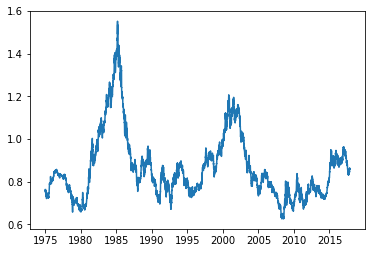

In [4]:
plt.plot(ts)

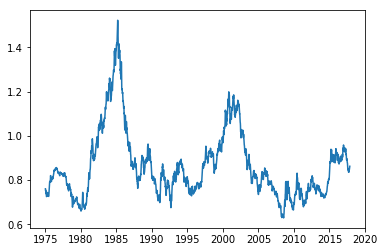

In [5]:
ts_week = ts.resample('W').mean()
plt.plot(ts_week)

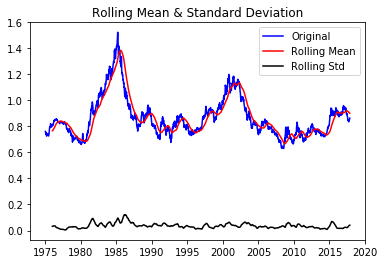

Results of Dickey-Fuller Test:
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


In [6]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_week)

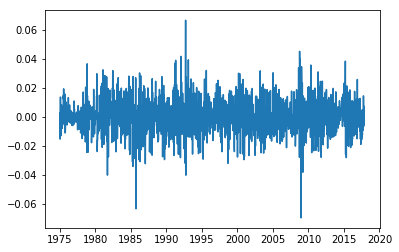

In [7]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

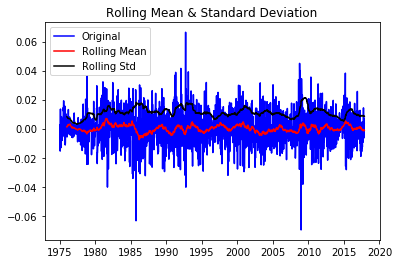

Results of Dickey-Fuller Test:
Test Statistic                  -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value (1%)              -3.433279
Critical Value (5%)              -2.862834
Critical Value (10%)             -2.567459
dtype: float64


In [8]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

In [9]:
#ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

Text(0.5,1,'Autocorrelation Function')

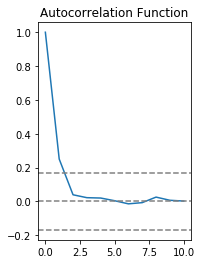

In [10]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

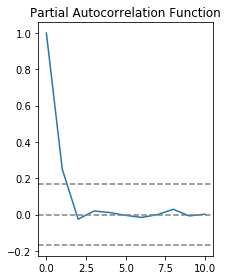

In [11]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5,1,'RSS: 0.2804')

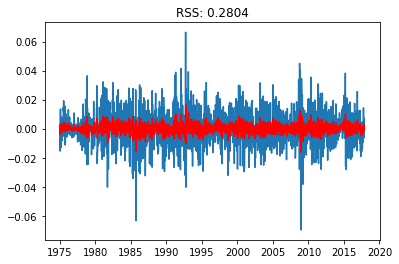

In [12]:
model = ARIMA(ts_week_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 2)   Log Likelihood                6871.319
Method:                       css-mle   S.D. of innovations              0.011
Date:                Wed, 26 Dec 2018   AIC                         -13730.638
Time:                        10:40:55   BIC                         -13696.363
Sample:                    01-12-1975   HQIC                        -13718.124
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.259e-05      0.000      0.143      0.886      -0.001       0.001
ar.L1.D.Value     1.0689      0.116      9.196      0.000       0.841       1.297
ar.L2.D.Value    -0.1011      0.093     

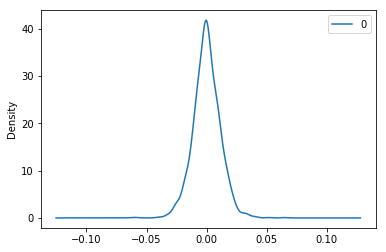

In [13]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [15]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1975-01-12    0.000053
1975-01-19   -0.002420
1975-01-26    0.000983
1975-02-02   -0.004140
1975-02-09   -0.001225
Freq: W-SUN, dtype: float64


C:\Users\NAEEN REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,'RMSE: 0.1185')

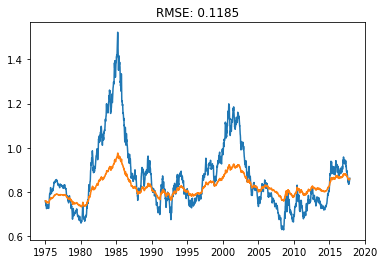

In [16]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [19]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

In [ ]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...




In [18]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


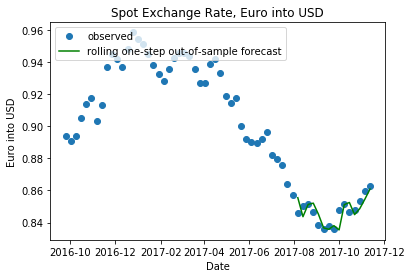

In [19]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')